# The Aiyagari model

Here we follow the work of Aiyagari and Huggett (and a range of other people). You might know it by now as the Standard Incomplete Markets (SIM) model. There are many resources to follow here. We will look at a few different implementations in Julia. We have done value function iteration before, this is the simplest method, so we will follow it here as well initially. 

## Model description

Aggregate behaviour is result of market interaction among large number of agents subject to idiosyncratic shocks. This involves asset trading as the main mechanism by which agents smooth consumption. There is also individual dynamics and uncertainty in this model. 

Aggregate variables are unchanging in this model. 

Model is built around the standard neoclassical growth model and is modified to include a role for uninsured idiosyncratic risk and liquidity / borrowing constraints.

## Model ingredients

Typical consumption savings problem in infinite horizon. There are two important features of this model. 

1. Idiosyncratic shocks -- The individual receives exogenous income shocks (normally due to change in labour productivity / employment status)
2. Incomplete markets -- The individuals cannot trade assets, there is no insurance in this market

We first deal with the case where there is no aggregate uncertainty.

This means that individuals are ex-ante the same, but ex-post they might differ.

Importantly, the input into this process, the earnings process, is exogenous. However, the wealth distribution generated from this process is endogenous.. 

## Solving the model

There are a few steps involved in solving the model, plus some techniques that we need to learn. Essentially we have three building blocks. 

1. Household consumption savings problem (this is the asset supply function)

In this part we need to solve for the HH problem (we will use VFI). Then we have to solve for the endogenous stationary distribution. Given this distribution and the HH decision we can solve for the aggregate asset supply

2. Asset demand function

This can easily be gained form the aggregate production function or the government. Think about this in the sense of a neoclassical growth model. 

3. Find the equilibrium in the asset market

Equlibrium refers to the prices and quantities that clear the market

### The household problem

To a certain extent we have dealt with this type of problem before, but here we will spell it out in detail.

We have a unit mass households. Each of these households are **price takers**. 

These are *ex-ante* identical infinitely lived households. They face idiosyncratic labour income shocks (i.e. they are said to earn stochastic income).

In terms of labour income, this depends on an exogenous state. It is important to recognise that the this state is exogenously given. You can imagine any reason why labour income might be different between households (i.e. productivity, employment status, etc.)

We assume that the exogenous state process follows a finite state Markov process (with a specific transition / stochastic matrix).

Agents have the ability save (and thereby self-insure) with a risk free interest rate bond up to some borrowing constraint. Agents do not have access to full set of state contingent Arrow securities, so this is an incomplete market (cannot fully insure against risks).

#### Bellman equation

The HH value equation solves the following Bellman equation
$$
    V(a,s) = \max_{c,a'} u(c) + \beta \sum_{s'} \Pi(s'|s)V(a',s') = \max_{c,a'} u(c)+\beta\mathbb{E}[V(s',a')|s]
$$
subject to 
$$
    c + a' = (1+r) a + w s = (1+r) a + y(s)
$$
and 
$$    a'\geq \underline a = -\phi
$$

In the above specification the households split their cash on hand between assets saved for tomorrow and consumption today. They make these choices so as to maximize expected utility subject to a borrowing constraint. 

We need to think about the steps that we need to take to implement this model. First, we are going to discretise assets and income. We want to discretise the continuum of possible asset states into a fine grid. We also want to calibrate the Markov chain for the income process so it is approximately an AR(1) process with normal innovations. 

## Discretising assets and income

If we want to use VFI we will have to discretise the grid for the state space, which in this case is $(s, a)$. We start with the easiest one to discretise, assets. 

### Discretising assets

Households will pick assets $a$ from a specific interval $[\underline{a},\infty)$. As you can see, the interval is continuous and we can't represent an infinite number of values in the computer's memory. So in terms of computation we will likely have to construct some finite grid. You might wonder, what happens then if we have to evaluate a point off this grid? In that case we can use some form of interpolation to give us an approximation of what the points would look like off the grid. This is why we dedicated some time to interpolation before. You might recall that this is similar to the idea of *fitted value function iteration* that we talked about in a previous session. 

How do we choose the grid that we are going to be working with? There are multiple options. 

However, for this specific problem there are going to be some criteria we have to work with. 

1. We need to make sure that the points are densely spaced around the borrowing constraint. This is a segment where the policuy function is going to be highly nonlinear and there will be a clustering of households.
2. We want to have fewer points at very high levels of assets. The reason is that at high asset levels we are capturing the wealthy households, but the policy function will be quite linear here. If we use linear interpolation here the approximation error will be small.


One of the easiest ways to produce an asset grid that will have these properties is the double exponential transformation on the uniformly spaced grid. 

We start off with uniformly spaced points $u_i$ on an interval $[0,\bar{u}]$. We then construct the gridpoints $a_i$ by applying the following transformation:

$$
a_i = \underline{a} + e^{e^{u_i}-1}-1 \tag{4}
$$

This produces a grid with minimum $\underline{a}$ and maximum $\underline{a} + e^{e^{\bar{u}}-1}-1$. To equate the latter with some desired maximum asset gridpoint $\bar{a}$, we write $\bar{u} = \log(1+\log(1+ \overline{a} - \underline{a}))$.

In [68]:
using Plots

In [69]:
function double_exponential_grid(n, a_min, a_max)
    u_max = log(1 + log(1 + a_max - a_min))
    u_grid = LinRange(0, u_max, n) # n points uniformly spaced on [0, u_max]
    a_grid = a_min .+ exp.(exp.(u_grid) .- 1) .- 1
    return a_grid
end

double_exponential_grid (generic function with 1 method)

In [70]:
a_grid = double_exponential_grid(50, 0, 10_000) # For 50 points between 0 and 10_000

50-element Vector{Float64}:
    0.0
    0.04975698153883745
    0.10459121897869572
    0.16516698552593123
    0.23225521534472748
    0.3067537111300265
    0.3897117511542112
    0.4823601769936814
    0.5861483391931348
    0.7027896635934308
    ⋮
  397.29360849547504
  558.1837984762485
  797.1067906665255
 1157.9643094241846
 1712.7444670937211
 2581.6825353699523
 3969.502746739219
 6231.89053821472
 9999.99999999999

Here is a more "engineered" version of the code above. Essentially the same code, but better coding practices applied.  

In [71]:
function dblexponentialspace(x_min::Real, x_max::Real, n::Int)
    n ≤ 2 && throw(error("Number of gridpoints must be larger than 2"))
    x_min > x_max && throw(error("`x_min` larger than `x_max`"))
    uniform_upper = log(1 + log(1 + x_max - x_min))
    uniform_grid = range(start=0, stop=uniform_upper, length=n) # uniform grid
    a_grid = @. x_min + exp(exp(uniform_grid) - 1) - 1 # double-exponential transformation
    return a_grid
end

dblexponentialspace (generic function with 1 method)

In [72]:
dbl_grid = dblexponentialspace(0, 10_000, 50)

50-element Vector{Float64}:
    0.0
    0.04975698153883745
    0.10459121897869572
    0.16516698552593123
    0.23225521534472748
    0.3067537111300265
    0.3897117511542112
    0.4823601769936814
    0.586148339193135
    0.7027896635934308
    ⋮
  397.2936084954743
  558.1837984762491
  797.1067906665284
 1157.9643094241846
 1712.7444670937211
 2581.6825353699523
 3969.5027467392333
 6231.89053821472
 9999.99999999999

There are other methods that would also work and deliver similar results. You can check out each of these in turn to see what results they deliver. 

In [73]:
"""
    logspace(x_min::Real, x_max::Real, n::Int) -> Vector{Float64}

Generate a vector of `n` points, evenly spaced on a logarithmic scale between `x_min` and `x_max`.

# Arguments
- `x_min::Real`: The minimum value (inclusive) in the generated vector.
- `x_max::Real`: The maximum value (inclusive) in the generated vector.
- `n::Int`: The number of points to generate in the vector.

# Returns
- `Vector{Float64}`: A vector containing the `n` points evenly spaced on a logarithmic scale.
"""
function logspace(x_min::Real, x_max::Real, n::Int)
    n ≤ 2 && throw(error("Number of gridpoints must be larger than 2"))
    x_min > x_max && throw(error("`x_min` larger than `x_max`"))
    return exp10.(range(x_min, x_max, n))
end

logspace

In [74]:
logspace(0, 10_000, 50)

50-element Vector{Float64}:
  1.0
  1.2067926406393561e204
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
  ⋮
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf

In [75]:
"""
    geomspace(x_min::Real, x_max::Real, n::Int) -> Vector{Float64}

Generate a vector of `n` points, evenly spaced on a logarithmic scale (geometric progression) between `x_min` and `x_max`.

# Arguments
- `x_min::Real`: The minimum value (inclusive) in the generated vector.
- `x_max::Real`: The maximum value (inclusive) in the generated vector.
- `n::Int`: The number of points to generate in the vector.

# Returns
- `Vector{Float64}`: A vector containing the `n` points evenly spaced on a logarithmic scale (geometric progression).
"""
function geomspace(x_min::Real, x_max::Real, n::Int)
    n ≤ 2 && throw(error("Number of gridpoints must be larger than 2"))
    x_min > x_max && throw(error("`x_min` larger than `x_max`"))
    x_min * x_max ≤ 0 && throw(error("Invalid combination of `x_min` and `x_max` values"))
    return exp10.(range(log10(x_min), log10(x_max), n))
end

geomspace

In [76]:
a_grid_g = geomspace(1, 10_000, 50)

50-element Vector{Float64}:
     1.0
     1.2067926406393286
     1.4563484775012439
     1.7575106248547918
     2.120950887920191
     2.5595479226995357
     3.088843596477481
     3.72759372031494
     4.498432668969445
     5.428675439323861
     ⋮
  2222.9964825261955
  2682.6957952797247
  3237.457542817643
  3906.939937054617
  4714.866363457395
  5689.866029018299
  6866.488450042998
  8286.427728546842
 10000.0

In [77]:
"""
    nonlinspace(x_min::Real, x_max::Real, n::Int, phi::Real) -> Vector{Float64}

Generate a vector of `n` unequally spaced points between `x_min` and `x_max`. The spacing is determined by the parameter `phi`, which must be greater than 1.

# Arguments
- `x_min::Real`: The minimum value (inclusive) in the generated vector.
- `x_max::Real`: The maximum value (inclusive) in the generated vector.
- `n::Int`: The number of points to generate in the vector.
- `phi::Real`: A parameter that determines the spacing of the points in the vector. The closer `phi` is to 1, the closer to equal spacing. The further away `phi` is from one, the more points are clustered around `x_min`.

# Returns
- `Vector{Float64}`: A vector containing the `n` unequally spaced points between `x_min` and `x_max`.
"""
function nonlinspace(x_min::Real, x_max::Real, n::Int, phi::Real)
    n ≤ 2 && throw(error("Number of gridpoints must be larger than 2"))
    x_min > x_max && throw(error("`x_min` larger than `x_max`"))
    phi ≤ 1 && throw(error("`phi` must be larger than one"))
    a_grid = Vector{Float64}(undef, n)
    a_grid[1] = x_min
    for i in 2:n-1
        a_grid[i] = a_grid[i-1] + (x_max - a_grid[i-1]) / ((n - i)^phi)
    end
    return a_grid
end

nonlinspace

In [78]:
a_grid_n = nonlinspace(0, 10_000, 50, 2)

50-element Vector{Float64}:
     0.0
     4.340277777777778
     8.865248226950355
    13.58695652173913
    18.51851851851852
    23.674242424242426
    29.069767441860467
    34.72222222222222
    40.65040650406504
    46.875
     ⋮
  1067.7083333333333
  1250.0
  1493.0555555555557
  1833.3333333333335
  2343.75
  3194.4444444444443
  4895.833333333333
 10000.0
     0.0

In [79]:
"""
    equilogspace(x_min::Real, x_max::Real, n::Int, pivot::Real) -> Vector{Float64}

Generate a vector of `n` points between `x_min` and `x_max` that are approximately equidistant in logarithmic scale. The `pivot` parameter determines the location of the pivot point. The closer `pivot` is to `x_min`, the more points are clustered around `x_min`.

# Arguments
- `x_min::Real`: The minimum value (inclusive) in the generated vector.
- `x_max::Real`: The maximum value (inclusive) in the generated vector.
- `n::Int`: The number of points to generate in the vector.
- `pivot::Real`: A parameter that determines the location of the pivot point.

# Returns
- `Vector{Float64}`: A vector containing the `n` points approximately equidistant in logarithmic scale between `x_min` and `x_max`.
"""

function equilogspace(x_min::Real, x_max::Real, n::Int, pivot::Real)
    n ≤ 2 && throw(error("Number of gridpoints must be larger than 2"))
    x_min > x_max && throw(error("`x_min` larger than `x_max`"))
    # if x_min + pivot < 0 
    #     x_min + pivot = pivot
    #     pivot += abs(x_min)
    a_grid = geomspace(x_min + pivot, x_max + pivot, n) .- pivot
    a_grid[1] = x_min # make sure that this is exactly equal to x_min
    return a_grid
end

equilogspace (generic function with 1 method)

In [80]:
a_grid_e = equilogspace(0, 10_000, 50, 2)

50-element Vector{Float64}:
     0.0
     0.3796931028752075
     0.8314696319359172
     1.3690143770592522
     2.0086101382876578
     2.769630949099387
     3.6751289364159705
     4.7525325939583
     6.0344776203913
     7.559795489225195
     ⋮
  2487.7698326062123
  2960.4440491998807
  3522.8538357673315
  4192.035180809368
  4988.2582964940175
  5935.641624866295
  7062.88241101953
  8404.125973063778
 10000.000000000004

#### Plotting our grid

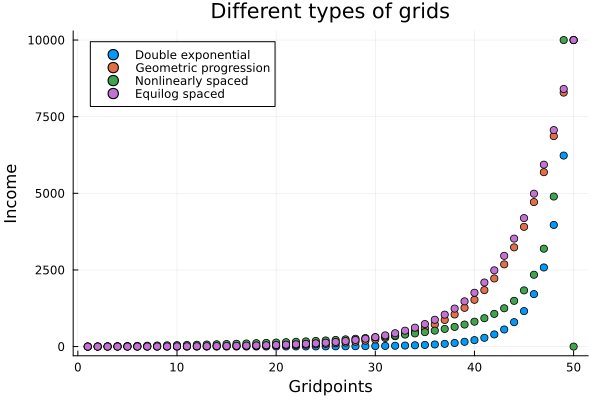

In [81]:
scatter(a_grid, ylabel="Income", xlabel="Gridpoints", label="Double exponential")
scatter!(a_grid_g, ylabel="Income", xlabel="Gridpoints", label="Geometric progression")
scatter!(a_grid_n, ylabel="Income", xlabel="Gridpoints", label="Nonlinearly spaced")
scatter!(a_grid_e, title="Different types of grids", ylabel="Income", xlabel="Gridpoints", label="Equilog spaced")

We see here the vastly greater concentration of gridpoints near the borrowing constraint: out of 50, the first 12 points are less than 1, the next 10 points are less than 5, and so on. Similarly, we see the thinly spaced points near the top: 6 points cover almost the entire span from 1000 to 10,000. With the *double* exponential, the ratio between each pair of successive points grows as we go higher on the grid.

#### Note on discretising asset space

The selection of gridpoints on the asset space is actually quite important and can differ for each of the problems under consideration. Some methods that I have not mentioned include adaptive grids, sparse grids and the endogenous grids. We will deal with endogenous grids in the endogenous gridpoint method. 

Take note that sparse grid methods are a really cool area of research and are used in many applications. If you want to learn more about those, you can look [here](https://github.com/sischei/crest_comp_econ) or [here](https://github.com/sischei/global_solution_yale19).

### Discretising income

This section is a bit more tricky, but worth thinking about. We will focus on one specific method (Rouwenhorst), but there are multiple ways to address this problem. 

We set up our problem for the incomplete markets model with the idea that there is a finite set of exogenous states. Each of these states associated with a specific income level. 

The state of each household follows a Markov process. There is some probablity that the state will transition from one state to another. We can represent this as a stochastic matrix. The stochastic matrix is given by $\pi_{ss'}$ and represents the probability of moving from any state $s$ to any state $s'$.

One way to think about the income process is to construct a simple version of the model where we would have different states for employment and unemployment. 

However, one could take a more sophisticated approach and model an AR(1) labour productivity shock that underlies the income process. For this AR(1) model we want to construct a discrete Markov chain process such that the moments of the original AR(1) process are matched.

This means that we can consider a sequence of discrete random variables, instead of dealing with a sequence of continuous random variables. 

We are discretising all the state variables of the Bellman equation, even the stochastic ones.